# Network Intrusion Detection with Deep Learning

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2" #model will be trained on GPU 0
#from keras.utils import multi_gpu_model

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


## Open Data

In [ ]:
import numpy as np
def load_matrices(file_name):
    with open(file_name, 'rb') as f:
        A = np.load(f)
        B = np.load(f)
        C = np.load(f)
        D = np.load(f)
        E = np.load(f)
        F = np.load(f)
    return (A,B,C,D,E,F)

In [ ]:
my_file = '../data_NSL/data.npy'
train, test, test2, y_train, y_test, y_test2 = load_matrices(my_file)

## The Model

In [32]:
# talos item
import talos as ta
import wrangle as wr
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live

# Keras items
from keras import backend as K
from keras.layers import Input, Dense 
from keras.layers import InputLayer
from keras.models import Model, Sequential
from keras.layers import Activation, Reshape, Dropout
from keras.optimizers import Adam
from keras.layers.embeddings import Embedding
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping
from keras.activations import relu, elu
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import PReLU
from keras.callbacks import TensorBoard
from keras.models import load_model

%matplotlib inline

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\chances\plots.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  Fi

In [34]:

def selu(x):
    """Scaled Exponential Linear Unit. (Klambauer et al., 2017)
    # Arguments
        x: A tensor or variable to compute the activation function for.
    # References
        - [Self-Normalizing Neural Networks](https://arxiv.org/abs/1706.02515)
    """
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * elu(x, alpha)


In [35]:
# then we load the dataset
x=train

input_dim = train.shape[1]
print(input_dim)

122


In [36]:
from keras.callbacks import ModelCheckpoint
filepath="./log3/taloslr_weights_a.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [37]:

filepath2="./log3/taloslr_weights_2a.best.hdf5"
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_acc', save_best_only=True, mode='max')
callbacks_list2 = [checkpoint2]

In [39]:
#actvation leakyrelu
LR= LeakyReLU(0.01)
LR.__name__ = 'lrelu'
#actvation prelu
#PR= PReLU()
#PR.__name__ = 'prelu'

In [40]:
# first we have to make sure to input data and params into the function
# add input parameters to the function
def dnn(x_train, y_train, x_val, y_val, params):

    input_dim = x_train.shape[1]

    input_img = Input(shape=(input_dim,))

    first_neuron=params['first_neuron']
    second_neuron=params['second_neuron']
    batch_size=params['batch_size']
    kernel_initial=params['kernel_initializer']
    lr=params['lr']
    activation=params['activation']
    
    print('activation=',activation)

    ###AE
    
    # replace the hyperparameter inputs with references to params dictionary 
    autoencoder = Sequential()
    #encoder
    
    if activation==PReLU: 
        autoencoder.add(Dense(first_neuron, input_shape=(input_dim,), kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
        autoencoder.add(Dense(second_neuron, kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
                   
        #decoder
        #model.add(Dense(8, activation=params['activation']))
        autoencoder.add(Dense(first_neuron, kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
        autoencoder.add(Dense(input_dim, activation='sigmoid', kernel_initializer=kernel_initial))
        
    else:
        autoencoder.add(Dense(first_neuron, input_shape=(input_dim,), activation=activation, kernel_initializer=kernel_initial))
        autoencoder.add(Dense(second_neuron, activation=activation, kernel_initializer=kernel_initial))
        #decoder
        #model.add(Dense(8, activation=params['activation']))
        autoencoder.add(Dense(first_neuron, activation=activation, kernel_initializer=kernel_initial))
        autoencoder.add(Dense(input_dim, activation='sigmoid', kernel_initializer=kernel_initial))
    
    #model = multi_gpu_model(model, gpus=1)
    autoencoder.summary()
    print(input_dim)

    input_img = Input(shape=(input_dim,))
    encoder_layer1 = autoencoder.layers[0]
    encoder_layer2 = autoencoder.layers[1]
    encoder = Model(input_img, encoder_layer2(encoder_layer1(input_img)))
    
    #encoder_layer1 = autoencoder.layers[0]
    #encoder_layer2 = autoencoder.layers[1]
    #encoder_layer3 = autoencoder.layers[2]
    #encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))
    encoder.summary()

    ## using binary cross entropy because from 122 features only 32 features (sudah dinormalisasi dalam rentang 0 dan 1) float and 90 features binary
    autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    #model.compile(loss=params['losses'],
    #              optimizer=params['optimizer'](),
    #              metrics=['acc', fmeasure_acc])
    
   

    
    history=autoencoder.fit(x,x,
                             epochs=params['epochs'],
                             batch_size=batch_size,
                              #shuffle=True,
                              #validation_split=0.2,
                              callbacks=callbacks_list,                    
                             #callbacks=[early_stopping])
                              validation_data=(test,test),
                              verbose=0)

    num_classes=5
    out2 = Dense(num_classes, activation='softmax',kernel_initializer=kernel_initial)(encoder.output)
    newmodel = Model(encoder.input,out2)
    
   
    newmodel.compile(loss='categorical_crossentropy', 
                     #optimizer='adam', 
                     optimizer= Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0, amsgrad=False),
                     metrics=['acc']) 
    newmodel.summary()


    history2a=newmodel.fit(x, y,
                           epochs=params['epochs2'],
                           batch_size=batch_size,
                           #validation_split=0.2,
                           callbacks=callbacks_list2,
                           #callbacks=[early_stopping],
                           validation_data=(test,y_test),
                           verbose=0)

    
    del encoder
    del autoencoder
    #del dnn_model
    
    tf.reset_default_graph()
    
    return history2a, newmodel #, encoder
    


In [43]:
# then we can go ahead and set the parameter space
p = {'first_neuron':[100, 80, 60],
     'second_neuron':[50, 40,30,20],
     'batch_size': [32,64,256],
     'epochs': [30],
     'epochs2': [50],
     'dropout': [0],
     'kernel_initializer': ['lecun_uniform','lecun_normal','he_normal','he_uniform','normal','glorot_uniform','glorot_normal'],
     'optimizer': [Adam],
     'lr':[0.1,0.01, 0.001,0.0001,0.00001],
     #'activation':[relu, elu,selu]}
     'activation':[relu, elu,selu, LR,PReLU]}

In [44]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras


    

In [45]:

t = ta.Scan(x, y, p, dnn, experiment_no='6', 
            grid_downsample=0.1,)

#experiment no 6 3780 kombinasi

  0%|          | 0/302 [00:00<?, ?it/s]

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0      

  0%|          | 1/302 [04:09<20:49:16, 249.02s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  1%|          | 2/302 [21:47<40:58:45, 491.75s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  1%|          | 3/302 [24:30<32:39:16, 393.17s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  1%|▏         | 4/302 [33:53<36:46:07, 444.19s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  2%|▏         | 5/302 [50:44<50:40:19, 614.21s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  2%|▏         | 6/302 [1:07:25<60:02:44, 730.29s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  2%|▏         | 7/302 [1:10:11<45:57:28, 560.84s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  3%|▎         | 8/302 [1:12:53<36:02:07, 441.25s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  3%|▎         | 9/302 [1:21:35<37:52:55, 465.45s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  3%|▎         | 10/302 [1:24:27<30:37:25, 377.55s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  4%|▎         | 11/302 [1:27:13<25:22:47, 313.98s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  4%|▍         | 12/302 [1:29:57<21:40:17, 269.03s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  4%|▍         | 13/302 [1:32:40<19:02:30, 237.20s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  5%|▍         | 14/302 [1:35:24<17:12:43, 215.15s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  5%|▍         | 15/302 [1:44:12<24:38:54, 309.18s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  5%|▌         | 16/302 [1:52:56<29:40:59, 373.63s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  6%|▌         | 17/302 [1:55:47<24:46:25, 312.93s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  6%|▌         | 18/302 [2:05:09<30:33:42, 387.40s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  6%|▋         | 19/302 [2:14:00<33:50:52, 430.57s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  7%|▋         | 20/302 [2:16:44<27:28:25, 350.73s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  7%|▋         | 21/302 [2:19:28<22:59:53, 294.64s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  7%|▋         | 22/302 [2:28:48<29:06:15, 374.20s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  8%|▊         | 23/302 [2:31:41<24:18:46, 313.71s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  8%|▊         | 24/302 [2:49:27<41:39:54, 539.55s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  8%|▊         | 25/302 [3:06:00<51:58:43, 675.54s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  9%|▊         | 26/302 [3:22:47<59:25:31, 775.11s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  9%|▉         | 27/302 [3:39:26<64:19:51, 842.15s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

  9%|▉         | 28/302 [3:48:43<57:35:25, 756.66s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 10%|▉         | 29/302 [3:51:28<43:54:41, 579.05s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 10%|▉         | 30/302 [3:54:21<34:33:30, 457.39s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 10%|█         | 31/302 [4:11:04<46:44:27, 620.91s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 11%|█         | 32/302 [4:13:47<36:16:31, 483.67s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 11%|█         | 33/302 [4:22:33<37:05:50, 496.47s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 11%|█▏        | 34/302 [4:31:20<37:38:25, 505.62s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 12%|█▏        | 35/302 [4:34:05<29:54:29, 403.26s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 12%|█▏        | 36/302 [4:42:49<32:28:21, 439.48s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 12%|█▏        | 37/302 [4:45:33<26:16:22, 356.91s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 13%|█▎        | 38/302 [5:02:19<40:27:28, 551.70s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 13%|█▎        | 39/302 [5:05:04<31:48:56, 435.50s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 13%|█▎        | 40/302 [5:13:48<33:37:59, 462.14s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 14%|█▎        | 41/302 [5:23:10<35:40:07, 491.98s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 14%|█▍        | 42/302 [5:41:03<48:07:20, 666.31s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 14%|█▍        | 43/302 [5:43:47<37:06:37, 515.82s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 15%|█▍        | 44/302 [5:46:40<29:35:19, 412.87s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 15%|█▍        | 45/302 [5:49:25<24:10:11, 338.57s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 15%|█▌        | 46/302 [5:58:12<28:04:56, 394.91s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 16%|█▌        | 47/302 [6:06:55<30:42:41, 433.57s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 16%|█▌        | 48/302 [6:23:33<42:32:03, 602.85s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 16%|█▌        | 49/302 [6:26:17<33:06:04, 471.01s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 17%|█▋        | 50/302 [6:29:02<26:32:58, 379.28s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 17%|█▋        | 51/302 [6:46:54<40:56:38, 587.25s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 17%|█▋        | 52/302 [6:55:37<39:25:49, 567.80s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 18%|█▊        | 53/302 [7:12:11<48:07:53, 695.88s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 18%|█▊        | 54/302 [7:14:56<36:57:17, 536.44s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 18%|█▊        | 55/302 [7:31:40<46:25:40, 676.68s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 19%|█▊        | 56/302 [7:48:12<52:43:01, 771.47s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 19%|█▉        | 57/302 [8:06:16<58:52:25, 865.08s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 19%|█▉        | 58/302 [8:15:01<51:43:23, 763.13s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 20%|█▉        | 59/302 [8:24:26<47:29:54, 703.68s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 20%|█▉        | 60/302 [8:33:46<44:24:44, 660.68s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 20%|██        | 61/302 [8:42:36<41:35:17, 621.23s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 21%|██        | 62/302 [8:59:20<49:04:15, 736.06s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 21%|██        | 63/302 [9:17:18<55:41:14, 838.81s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 21%|██        | 64/302 [9:35:03<59:56:21, 906.64s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 22%|██▏       | 65/302 [9:37:48<45:01:41, 683.97s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 22%|██▏       | 66/302 [9:40:33<34:38:14, 528.37s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 22%|██▏       | 67/302 [9:58:40<45:25:58, 696.00s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 23%|██▎       | 68/302 [10:01:31<35:00:33, 538.60s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 23%|██▎       | 69/302 [10:04:16<27:36:08, 426.47s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 23%|██▎       | 70/302 [10:13:04<29:26:27, 456.84s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 24%|██▎       | 71/302 [10:31:16<41:32:53, 647.51s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 24%|██▍       | 72/302 [10:40:32<39:36:29, 619.96s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 24%|██▍       | 73/302 [10:57:11<46:40:46, 733.83s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 25%|██▍       | 74/302 [11:13:49<51:29:02, 812.90s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 25%|██▍       | 75/302 [11:22:39<45:54:15, 728.00s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 25%|██▌       | 76/302 [11:31:53<42:25:29, 675.79s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 25%|██▌       | 77/302 [12:53:13<121:04:40, 1937.25s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 26%|██▌       | 78/302 [12:56:05<87:34:51, 1407.55s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 26%|██▌       | 79/302 [12:58:50<64:06:25, 1034.91s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 26%|██▋       | 80/302 [13:08:10<55:01:29, 892.29s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 27%|██▋       | 81/302 [13:16:57<48:03:27, 782.84s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 27%|██▋       | 82/302 [13:33:31<51:41:59, 846.00s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 27%|██▋       | 83/302 [13:42:14<45:34:14, 749.11s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 28%|██▊       | 84/302 [13:44:58<34:43:58, 573.57s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 28%|██▊       | 85/302 [13:54:13<34:14:47, 568.14s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 28%|██▊       | 86/302 [14:02:53<33:12:39, 553.52s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 29%|██▉       | 87/302 [14:12:16<33:13:40, 556.37s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 29%|██▉       | 88/302 [14:28:57<41:00:35, 689.88s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 29%|██▉       | 89/302 [14:31:41<31:29:08, 532.15s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 30%|██▉       | 90/302 [14:40:25<31:11:00, 529.53s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 30%|███       | 91/302 [14:58:01<40:18:16, 687.66s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 30%|███       | 92/302 [15:06:49<37:19:02, 639.73s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 31%|███       | 93/302 [15:16:09<35:45:09, 615.83s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 31%|███       | 94/302 [15:32:51<42:16:41, 731.74s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 31%|███▏      | 95/302 [15:35:36<32:17:34, 561.61s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 32%|███▏      | 96/302 [15:44:28<31:37:22, 552.63s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 32%|███▏      | 97/302 [15:53:19<31:06:07, 546.18s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 32%|███▏      | 98/302 [16:11:09<39:51:41, 703.44s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 33%|███▎      | 99/302 [16:13:53<30:32:04, 541.50s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 33%|███▎      | 100/302 [16:16:44<24:09:05, 430.42s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 33%|███▎      | 101/302 [16:19:34<19:40:24, 352.36s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 34%|███▍      | 102/302 [16:28:49<22:56:42, 413.01s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 34%|███▍      | 103/302 [16:31:32<18:40:58, 337.98s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 34%|███▍      | 104/302 [16:48:18<29:36:57, 538.47s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 35%|███▍      | 105/302 [16:51:09<23:26:00, 428.22s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 35%|███▌      | 106/302 [16:53:54<19:00:51, 349.24s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 35%|███▌      | 107/302 [17:03:11<22:17:24, 411.51s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 36%|███▌      | 108/302 [17:11:59<24:03:42, 446.51s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 36%|███▌      | 109/302 [17:14:50<19:30:20, 363.84s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 36%|███▋      | 110/302 [17:31:20<29:25:11, 551.62s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 37%|███▋      | 111/302 [17:47:51<36:16:18, 683.66s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 37%|███▋      | 112/302 [17:50:36<27:51:22, 527.80s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 37%|███▋      | 113/302 [17:53:18<21:57:47, 418.35s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 38%|███▊      | 114/302 [18:02:00<23:28:01, 449.37s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 38%|███▊      | 115/302 [18:18:36<31:51:18, 613.25s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 38%|███▊      | 116/302 [18:27:21<30:19:11, 586.83s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 39%|███▊      | 117/302 [18:36:05<29:11:40, 568.11s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 39%|███▉      | 118/302 [18:45:25<28:53:53, 565.40s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 39%|███▉      | 119/302 [18:54:07<28:05:21, 552.58s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 40%|███▉      | 120/302 [19:02:55<27:33:42, 545.18s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 40%|████      | 121/302 [19:11:44<27:09:58, 540.32s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 40%|████      | 122/302 [19:20:30<26:47:42, 535.91s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 41%|████      | 123/302 [19:23:21<21:12:20, 426.48s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 41%|████      | 124/302 [19:40:01<29:35:40, 598.54s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 41%|████▏     | 125/302 [19:48:51<28:24:56, 577.95s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 42%|████▏     | 126/302 [20:05:28<34:24:08, 703.69s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 42%|████▏     | 127/302 [20:21:56<38:21:05, 788.94s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 42%|████▏     | 128/302 [20:31:13<34:46:41, 719.55s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 43%|████▎     | 129/302 [20:33:59<26:35:24, 553.32s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 43%|████▎     | 130/302 [23:44:24<182:15:36, 3814.75s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 43%|████▎     | 131/302 [24:00:58<141:00:27, 2968.58s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 44%|████▎     | 132/302 [24:17:40<112:19:56, 2378.80s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 44%|████▍     | 133/302 [24:34:27<92:21:02, 1967.23s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 44%|████▍     | 134/302 [24:50:57<78:07:14, 1674.02s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 45%|████▍     | 135/302 [25:00:11<62:04:10, 1338.02s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 45%|████▌     | 136/302 [25:08:58<50:28:29, 1094.64s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 45%|████▌     | 137/302 [25:11:48<37:27:39, 817.33s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 46%|████▌     | 138/302 [25:20:32<33:12:57, 729.13s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 46%|████▌     | 139/302 [25:23:15<25:19:30, 559.33s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 46%|████▋     | 140/302 [25:32:33<25:09:20, 559.01s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 47%|████▋     | 141/302 [25:35:16<19:41:19, 440.25s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 47%|████▋     | 142/302 [25:51:48<26:55:02, 605.64s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 47%|████▋     | 143/302 [25:54:32<20:53:49, 473.14s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 48%|████▊     | 144/302 [26:12:23<28:38:39, 652.66s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 48%|████▊     | 145/302 [26:15:14<22:09:14, 507.99s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 48%|████▊     | 146/302 [26:23:55<22:10:57, 511.91s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 49%|████▊     | 147/302 [26:26:45<17:38:04, 409.58s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 49%|████▉     | 148/302 [26:43:27<25:07:04, 587.17s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 49%|████▉     | 149/302 [26:52:13<24:10:32, 568.84s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 50%|████▉     | 150/302 [27:08:48<29:24:59, 696.71s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 50%|█████     | 151/302 [27:18:04<27:27:05, 654.47s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 50%|█████     | 152/302 [27:34:53<31:42:06, 760.84s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 51%|█████     | 153/302 [27:51:34<34:28:13, 832.84s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 51%|█████     | 154/302 [28:00:15<30:23:47, 739.37s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 51%|█████▏    | 155/302 [28:08:56<27:30:56, 673.85s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 52%|█████▏    | 156/302 [28:11:47<21:12:24, 522.91s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 52%|█████▏    | 157/302 [28:14:34<16:45:49, 416.20s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 52%|█████▏    | 158/302 [28:17:17<13:36:46, 340.32s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 53%|█████▎    | 159/302 [28:26:00<15:41:33, 395.06s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 53%|█████▎    | 160/302 [28:42:47<22:49:35, 578.70s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 53%|█████▎    | 161/302 [28:59:29<27:37:47, 705.44s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 54%|█████▎    | 162/302 [29:08:11<25:17:51, 650.51s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 54%|█████▍    | 163/302 [29:24:55<29:12:51, 756.63s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 54%|█████▍    | 164/302 [29:34:12<26:42:10, 696.60s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 55%|█████▍    | 165/302 [29:42:55<24:32:01, 644.68s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 55%|█████▍    | 166/302 [29:51:35<22:56:37, 607.33s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 55%|█████▌    | 167/302 [30:00:13<21:46:05, 580.48s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 56%|█████▌    | 168/302 [30:08:59<20:59:44, 564.07s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 56%|█████▌    | 169/302 [30:11:43<16:24:11, 444.00s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 56%|█████▋    | 170/302 [30:20:26<17:09:04, 467.76s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 57%|█████▋    | 171/302 [30:29:05<17:35:08, 483.27s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 57%|█████▋    | 172/302 [30:47:03<23:53:10, 661.47s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 57%|█████▋    | 173/302 [30:55:50<22:15:21, 621.10s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 58%|█████▊    | 174/302 [31:04:33<21:02:10, 591.64s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 58%|█████▊    | 175/302 [31:21:13<25:11:37, 714.15s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 58%|█████▊    | 176/302 [31:23:56<19:12:43, 548.92s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 59%|█████▊    | 177/302 [31:32:44<18:50:43, 542.75s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 59%|█████▉    | 178/302 [31:35:27<14:46:12, 428.81s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 59%|█████▉    | 179/302 [31:52:02<20:26:57, 598.52s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 60%|█████▉    | 180/302 [32:08:51<24:27:44, 721.84s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 60%|█████▉    | 181/302 [32:18:07<22:34:53, 671.85s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 60%|██████    | 182/302 [32:34:40<25:36:28, 768.24s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 61%|██████    | 183/302 [32:43:54<23:16:27, 704.10s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 61%|██████    | 184/302 [32:46:40<17:46:56, 542.51s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 61%|██████▏   | 185/302 [32:55:28<17:29:43, 538.32s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 62%|██████▏   | 186/302 [33:04:08<17:10:12, 532.87s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 62%|██████▏   | 187/302 [33:12:52<16:56:12, 530.19s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 62%|██████▏   | 188/302 [33:15:36<13:18:45, 420.40s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 63%|██████▎   | 189/302 [33:24:23<14:11:53, 452.33s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 63%|██████▎   | 190/302 [33:33:38<15:01:25, 482.90s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 63%|██████▎   | 191/302 [33:42:19<15:14:30, 494.33s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 64%|██████▎   | 192/302 [33:51:40<15:42:56, 514.34s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 64%|██████▍   | 193/302 [34:09:23<20:33:25, 678.95s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 64%|██████▍   | 194/302 [34:25:53<23:10:12, 772.34s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 65%|██████▍   | 195/302 [34:42:27<24:56:02, 838.90s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 65%|██████▍   | 196/302 [34:59:14<26:11:18, 889.42s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 65%|██████▌   | 197/302 [35:01:58<19:35:41, 671.82s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 66%|██████▌   | 198/302 [35:18:39<22:15:15, 770.34s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 66%|██████▌   | 199/302 [35:27:56<20:12:33, 706.35s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 66%|██████▌   | 200/302 [35:36:45<18:30:29, 653.23s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 67%|██████▋   | 201/302 [35:54:39<21:51:59, 779.40s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 67%|██████▋   | 202/302 [35:57:22<16:30:40, 594.40s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 67%|██████▋   | 203/302 [37:13:38<49:11:45, 1788.95s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 68%|██████▊   | 204/302 [37:22:57<38:39:22, 1420.03s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 68%|██████▊   | 205/302 [37:25:48<28:09:54, 1045.30s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 68%|██████▊   | 206/302 [37:42:19<27:26:15, 1028.91s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 69%|██████▊   | 207/302 [37:51:02<23:08:53, 877.19s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 69%|██████▉   | 208/302 [37:53:55<17:23:28, 666.05s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 69%|██████▉   | 209/302 [37:56:47<13:22:48, 517.94s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 70%|██████▉   | 210/302 [38:05:34<13:18:18, 520.63s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 70%|██████▉   | 211/302 [38:08:21<10:28:44, 414.55s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 70%|███████   | 212/302 [38:17:14<11:15:09, 450.10s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 71%|███████   | 213/302 [38:26:36<11:57:26, 483.67s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 71%|███████   | 214/302 [38:29:22<9:29:35, 388.36s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 71%|███████   | 215/302 [38:46:01<13:48:42, 571.52s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 72%|███████▏  | 216/302 [38:55:22<13:34:31, 568.27s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 72%|███████▏  | 217/302 [38:58:07<10:33:34, 447.23s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 72%|███████▏  | 218/302 [39:00:59<8:30:40, 364.77s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 73%|███████▎  | 219/302 [39:09:47<9:32:04, 413.54s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 73%|███████▎  | 220/302 [39:26:42<13:31:51, 594.04s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 73%|███████▎  | 221/302 [39:43:46<16:16:21, 723.23s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 74%|███████▎  | 222/302 [40:00:23<17:53:43, 805.29s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 74%|███████▍  | 223/302 [40:03:16<13:30:39, 615.68s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 74%|███████▍  | 224/302 [40:12:03<12:45:45, 589.04s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 75%|███████▍  | 225/302 [40:20:54<12:13:31, 571.57s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 75%|███████▍  | 226/302 [40:29:41<11:47:01, 558.18s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 75%|███████▌  | 227/302 [40:39:04<11:39:24, 559.53s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 75%|███████▌  | 228/302 [40:57:08<14:44:19, 717.02s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 76%|███████▌  | 229/302 [40:59:53<11:10:51, 551.39s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 76%|███████▌  | 230/302 [41:08:40<10:52:50, 544.03s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 76%|███████▋  | 231/302 [41:11:24<8:28:45, 429.94s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 77%|███████▋  | 232/302 [41:29:30<12:11:24, 626.92s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 77%|███████▋  | 233/302 [41:38:23<11:28:21, 598.57s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 77%|███████▋  | 234/302 [41:47:11<10:54:21, 577.38s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 78%|███████▊  | 235/302 [41:49:59<8:27:50, 454.79s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 78%|███████▊  | 236/302 [41:58:51<8:45:42, 477.92s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 78%|███████▊  | 237/302 [42:07:45<8:56:01, 494.79s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 79%|███████▉  | 238/302 [42:24:21<11:28:02, 645.04s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 79%|███████▉  | 239/302 [42:27:08<8:46:43, 501.64s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 79%|███████▉  | 240/302 [42:35:56<8:46:29, 509.50s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 80%|███████▉  | 241/302 [42:45:25<8:56:01, 527.24s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 80%|████████  | 242/302 [42:54:53<8:59:40, 539.68s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 80%|████████  | 243/302 [43:11:36<11:07:16, 678.59s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 81%|████████  | 244/302 [43:28:31<12:33:38, 779.63s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 81%|████████  | 245/302 [43:37:23<11:09:51, 705.11s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 81%|████████▏ | 246/302 [43:40:15<8:28:57, 545.31s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 82%|████████▏ | 247/302 [43:43:00<6:35:13, 431.16s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 82%|████████▏ | 248/302 [44:01:02<9:23:50, 626.49s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 82%|████████▏ | 249/302 [44:03:57<7:13:42, 490.98s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 83%|████████▎ | 250/302 [44:06:41<5:40:37, 393.02s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 83%|████████▎ | 251/302 [48:05:10<64:42:39, 4567.83s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 83%|████████▎ | 252/302 [48:07:54<45:05:33, 3246.67s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 84%|████████▍ | 253/302 [48:24:44<35:03:21, 2575.54s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 84%|████████▍ | 254/302 [48:27:35<24:43:28, 1854.35s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 84%|████████▍ | 255/302 [48:36:56<19:08:34, 1466.27s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 85%|████████▍ | 256/302 [48:53:38<16:57:14, 1326.83s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 85%|████████▌ | 257/302 [48:56:22<12:13:36, 978.14s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 85%|████████▌ | 258/302 [49:05:06<10:17:15, 841.71s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 86%|████████▌ | 259/302 [49:07:49<7:37:24, 638.26s/it] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 86%|████████▌ | 260/302 [49:10:35<5:47:35, 496.55s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 86%|████████▋ | 261/302 [49:19:57<5:52:43, 516.18s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 87%|████████▋ | 262/302 [49:29:21<5:53:37, 530.44s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 87%|████████▋ | 263/302 [49:38:39<5:50:12, 538.79s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 87%|████████▋ | 264/302 [49:48:01<5:45:41, 545.84s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 88%|████████▊ | 265/302 [49:56:52<5:33:52, 541.42s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 88%|████████▊ | 266/302 [49:59:45<4:18:26, 430.75s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 88%|████████▊ | 267/302 [50:08:30<4:27:46, 459.04s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 89%|████████▊ | 268/302 [50:25:17<5:53:21, 623.57s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 89%|████████▉ | 269/302 [50:43:05<6:56:14, 756.82s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 20,932
Trainable params: 20,932
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 89%|████████▉ | 270/302 [50:51:51<6:06:39, 687.48s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 90%|████████▉ | 271/302 [50:54:35<4:34:06, 530.52s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 90%|█████████ | 272/302 [51:03:24<4:24:57, 529.92s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 90%|█████████ | 273/302 [51:20:05<5:24:27, 671.31s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 91%|█████████ | 274/302 [51:22:49<4:02:15, 519.13s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 30,752
Trainable params: 30,752
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 91%|█████████ | 275/302 [51:25:33<3:05:44, 412.75s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 32,762
Trainable params: 32,762
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 91%|█████████▏| 276/302 [51:28:18<2:26:32, 338.16s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 92%|█████████▏| 277/302 [51:45:05<3:44:33, 538.94s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 92%|█████████▏| 278/302 [51:54:25<3:38:04, 545.19s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 92%|█████████▏| 279/302 [52:10:54<4:20:05, 678.51s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 93%|█████████▎| 280/302 [52:19:45<3:52:32, 634.21s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 93%|█████████▎| 281/302 [52:36:28<4:20:42, 744.90s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 93%|█████████▎| 282/302 [52:53:00<4:32:57, 818.87s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 94%|█████████▎| 283/302 [52:55:44<3:17:08, 622.53s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 27,852
Trainable params: 27,852
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 94%|█████████▍| 284/302 [53:05:03<3:01:02, 603.50s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 94%|█████████▍| 285/302 [53:14:20<2:46:59, 589.40s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 95%|█████████▍| 286/302 [53:32:05<3:15:15, 732.20s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 95%|█████████▌| 287/302 [53:40:56<2:47:54, 671.63s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 95%|█████████▌| 288/302 [53:49:45<2:26:45, 628.94s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 96%|█████████▌| 289/302 [53:58:34<2:09:46, 598.99s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 18,512
Trainable params: 18,512
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 96%|█████████▌| 290/302 [54:07:18<1:55:18, 576.53s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 96%|█████████▋| 291/302 [54:16:02<1:42:47, 560.68s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 97%|█████████▋| 292/302 [54:24:51<1:31:51, 551.18s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 97%|█████████▋| 293/302 [54:33:36<1:21:30, 543.37s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 97%|█████████▋| 294/302 [54:50:16<1:30:42, 680.28s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 98%|█████████▊| 295/302 [54:53:00<1:01:18, 525.52s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 98%|█████████▊| 296/302 [55:09:46<1:06:58, 669.70s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 98%|█████████▊| 297/302 [55:18:32<52:12, 626.51s/it]  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 24,632
Trainable params: 24,632
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 99%|█████████▊| 298/302 [55:27:17<39:43, 595.97s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 19,722
Trainable params: 19,722
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 99%|█████████▉| 299/302 [55:43:47<35:42, 714.17s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 23,022
Trainable params: 23,022
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

 99%|█████████▉| 300/302 [56:01:37<27:21, 820.92s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                7380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               7442      
Total params: 17,302
Trainable params: 17,302
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

100%|█████████▉| 301/302 [56:04:28<10:26, 626.17s/it]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                9840      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 122)               9882      
Total params: 26,242
Trainable params: 26,242
Non-trainable params: 0
_________________________________________________________________
122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 122)               0         
_________________________________________________________________
de

100%|██████████| 302/302 [56:22:28<00:00, 762.28s/it]


Scan Finished!


In [49]:
x.shape



(125973, 122)

In [50]:
t.data

,round_epochs,val_loss,val_acc,loss,acc,first_neuron,second_neuron,batch_size,epochs,epochs2,dropout,kernel_initializer,optimizer,lr,activation
1,50,2.2891203588928373,0.7409510290986515,0.24973432043203547,0.9748041246948062,100,20,256,30,50,0,normal,<class 'keras.optimizers.Adam'>,0.1,<function selu at 0x000001A09D099EA0>
2,50,9.175102900578842,0.43075762952448543,5.55740574434989,0.6547672914079719,80,30,32,30,50,0,lecun_uniform,<class 'keras.optimizers.Adam'>,0.1,<function selu at 0x000001A09D099EA0>
3,50,1.5935581889111916,0.8304648687012065,0.0041217571304593475,0.9986346280552182,60,20,256,30,50,0,glorot_uniform,<class 'keras.optimizers.Adam'>,0.01,<function relu at 0x000001A0ACA80EA0>
4,50,5.557396908699832,0.6552075940383251,2.928849538471083,0.8182785200012639,80,40,64,30,50,0,lecun_uniform,<class 'keras.optimizers.Adam'>,0.1,<function selu at 0x000001A09D099EA0>
5,50,10.78591138881686,0.33081973030518097,8.66960930978528,0.46186087494998534,100,50,32,30,50,0,he_normal,<class 'keras.optimizers.Adam'>,0.1,<function relu at 0x000001A0ACA80EA0>
6,50,1.7780976444377046,0.794402058197303,0.002741328584130122,0.9990474149222452,80,40,32,30,50,0,he_normal,<class 'keras.optimizers.Adam'>,0.001,<function relu at 0x000001A0ACA80EA0>
7,50,1.344336941573872,0.7723562810503903,0.043862644084352614,0.989696204742286,100,40,256,30,50,0,glorot_uniform,<class 'keras.optimizers.Adam'>,0.1,<function relu at 0x000001A0ACA80EA0>
8,50,1.475861131510386,0.7941359119943222,0.005281924664807312,0.9985076167115176,60,20,256,30,50,0,glorot_normal,<class 'keras.optimizers.Adam'>,0.001,<function elu at 0x000001A0ACA80C80>
9,50,9.175102859291309,0.43075762952448543,5.4027695366603306,0.6638962317359818,80,50,64,30,50,0,glorot_normal,<class 'keras.optimizers.Adam'>,0.1,<function elu at 0x000001A0ACA80C80>
10,50,1.7717065665212568,0.7899662881476224,0.00577460674090476,0.9983409143229105,60,20,256,30,50,0,he_uniform,<class 'keras.optimizers.Adam'>,0.01,<function selu at 0x000001A09D099EA0>


In [55]:
r = ta.Reporting(t)

In [57]:
r.high('val_acc')

'0.8333481192334989'

In [56]:
r.best_params()

array([['0.01', '256', '30', '20', "<class 'keras.optimizers.Adam'>",
        'he_uniform', '50', '0', '<function relu at 0x000001A0ACA80EA0>',
        '100', 0],
       ['0.01', '256', '30', '20', "<class 'keras.optimizers.Adam'>",
        'glorot_uniform', '50', '0',
        '<function relu at 0x000001A0ACA80EA0>', '60', 1],
       ['0.1', '256', '30', '40', "<class 'keras.optimizers.Adam'>",
        'glorot_normal', '50', '0',
        '<function relu at 0x000001A0ACA80EA0>', '60', 2],
       ['0.01', '256', '30', '50', "<class 'keras.optimizers.Adam'>",
        'normal', '50', '0', '<function elu at 0x000001A0ACA80C80>',
        '100', 3],
       ['0.01', '64', '30', '50', "<class 'keras.optimizers.Adam'>",
        'glorot_normal', '50', '0',
        '<function relu at 0x000001A0ACA80EA0>', '80', 4],
       ['0.01', '256', '30', '30', "<class 'keras.optimizers.Adam'>",
        'he_uniform', '50', '0', '<function selu at 0x000001A09D099EA0>',
        '100', 5],
       ['0.01', '64', 

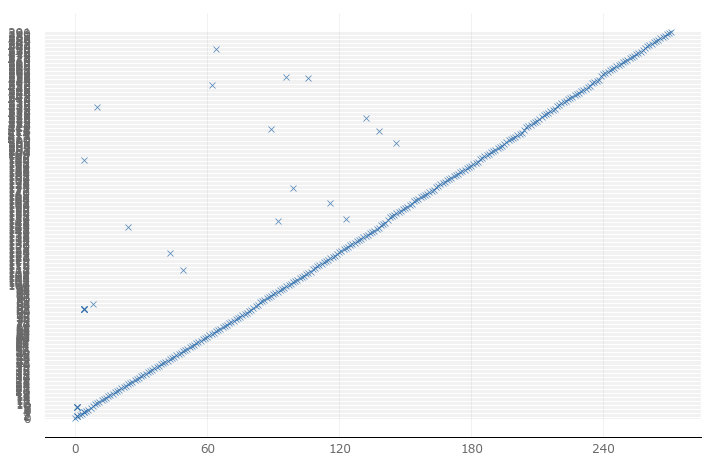

In [60]:
r.plot_regs()

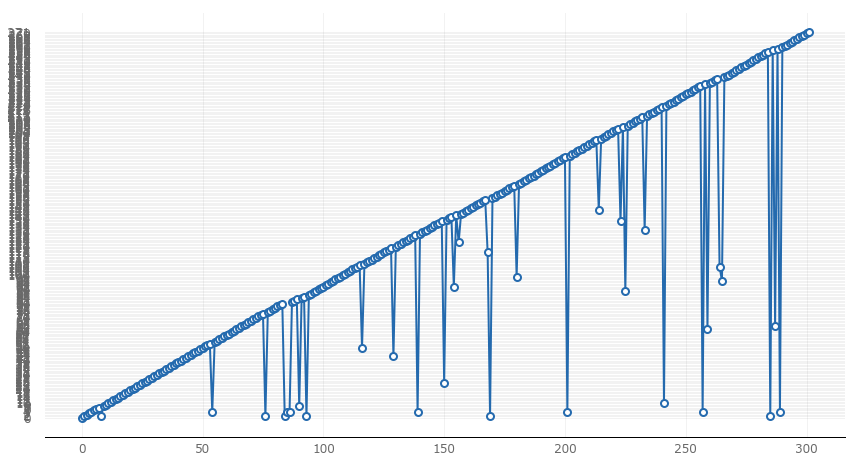

In [61]:
r.plot_line()

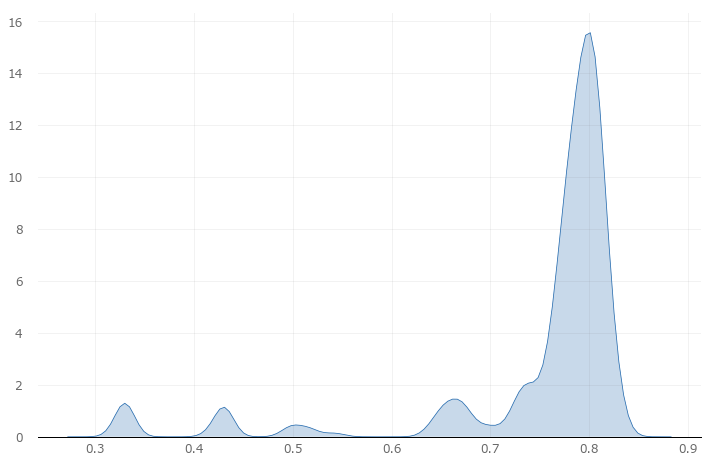

In [62]:
r.plot_kde('val_acc')

In [73]:
# this is the size of our encoded representations# this i 
input_dim = train.shape[1]
print(input_dim)

input_img = Input(shape=(input_dim,))
x = Dense(100, activation='relu', kernel_initializer='he_uniform')(input_img)
y = Dense(50, activation='relu', kernel_initializer='he_uniform')(x)
decoded = Dense(100, activation='relu', kernel_initializer='he_uniform')(y)
z = Dense(input_dim, activation='sigmoid', kernel_initializer='he_uniform')(decoded)
autoencoder = Model(input_img, z)
autoencoder.summary()

122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 122)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               12300     
_________________________________________________________________
dense_15 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_16 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_17 (Dense)             (None, 122)               12322     
Total params: 34,772
Trainable params: 34,772
Non-trainable params: 0
_________________________________________________________________


In [74]:
##loading autoencoder untuk data tes
# load weights
autoencoder.load_weights("./log3/taloslr_weights_a.best.hdf5")
# Compile model (required to make predictions)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")
scores = autoencoder.evaluate(test, test, verbose=0)
print("%s: %.2f%%" % (autoencoder.metrics_names[1], scores[1]*100))

Created model and loaded weights from file
acc: 92.24%


In [75]:
# this is the size of our encoded representations# this i 
input_dim = train.shape[1]
print(input_dim)

input_img = Input(shape=(input_dim,))
x = Dense(100, activation='relu', kernel_initializer='he_uniform')(input_img)
y = Dense(20, activation='relu', kernel_initializer='he_uniform')(x)
decoded = Dense(100, activation='relu', kernel_initializer='he_uniform')(y)
z = Dense(input_dim, activation='sigmoid', kernel_initializer='he_uniform')(decoded)
autoencoder = Model(input_img, z)
autoencoder.summary()



num_classes=5
#encoder is the model of the autoencoder slice in the middle 
encoder = Model(input_img, y)
# define new model encoder->Dense  10 neurons with soft max for classification 
out2 = Dense(num_classes, activation='softmax', kernel_initializer='he_uniform')(encoder.output)
newmodel = Model(encoder.input,out2)
newmodel.summary()

122
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 122)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               12300     
_________________________________________________________________
dense_19 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_20 (Dense)             (None, 100)               2100      
_________________________________________________________________
dense_21 (Dense)             (None, 122)               12322     
Total params: 28,742
Trainable params: 28,742
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in

In [76]:
##loading autoencoder untuk data tes
# load weights
newmodel.load_weights("./log3/taloslr_weights_2a.best.hdf5")
# Compile model (required to make predictions)
newmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")
scores = newmodel.evaluate(test, y_test, verbose=0)
print("%s: %.2f%%" % (newmodel.metrics_names[1], scores[1]*100))

Created model and loaded weights from file
acc: 83.33%


In [77]:
preds = newmodel.predict(test)
pred_lbls = np.argmax(preds, axis=1)
true_lbls = np.argmax(y_test, axis=1)
# With the confusion matrix, we can aggregate model predictions
# This helps to understand the mistakes and refine the model

In [78]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_lbls, pred_lbls)

array([[6260, 1140,   58,    0,    0],
       [  86, 9390,  232,    2,    1],
       [ 199,  158, 2062,    2,    0],
       [  14, 1665,   14, 1061,    0],
       [   0,   77,  104,    5,   14]], dtype=int64)

In [79]:
from sklearn.metrics import classification_report
outcomes = ['DoS', 'normal' ,'Probe' ,'U2R','R2L' ]
class_names=outcomes

target_names = ["Class {}".format(i) for i in range(5)]
print(classification_report(true_lbls, pred_lbls, target_names=class_names, digits=5))
#print(classification_report(Y_test, y_predict))

              precision    recall  f1-score   support

         DoS    0.95441   0.83937   0.89320      7458
      normal    0.75543   0.96694   0.84820      9711
       Probe    0.83482   0.85171   0.84318      2421
         U2R    0.99159   0.38526   0.55492      2754
         R2L    0.93333   0.07000   0.13023       200

    accuracy                        0.83335     22544
   macro avg    0.89392   0.62266   0.65395     22544
weighted avg    0.86021   0.83335   0.82035     22544



In [90]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(b=None)

Confusion matrix, without normalization
[[6260 1140   58    0    0]
 [  86 9390  232    2    1]
 [ 199  158 2062    2    0]
 [  14 1665   14 1061    0]
 [   0   77  104    5   14]]


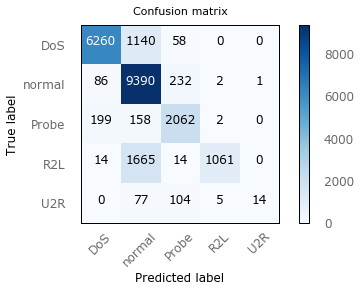

In [91]:
outcomes = ['DoS', 'normal','Probe' ,'R2L', 'U2R']
class_names=outcomes


results = confusion_matrix(true_lbls, pred_lbls)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(results, classes=class_names,
                      title='Confusion matrix')

#print(classification_report(y_test, deepprediction, target_names=class_names, digits=5))